In [ ]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm
 
from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints, files_to_datapoints_imagenet
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [ ]:
"""
There exists 4 datasets. The main one is the uncommented bellow.
There also exists a dataset of MNIST recorded by a different headset, a dataset of generated data used to test the correctness of the pipeline.
The imagenet dataset was a last ditch effort to see if we could achieve better results from that. Could not :(

Also, interpolated clean data contains data that has had channels with a corrlation below 0.1 repaired with spherical spline interpolation.
"""

#files = glob.glob('./Datasets/MindBigData-EP-v1.0/*.csv')
files = glob.glob('./Datasets/Interpolated_Clean_Data/*.csv')
#files = glob.glob('./Datasets/GeneratedData/*.csv')
#files = glob.glob('./Datasets/MindBigData-Imagenet-IN/MindBigData-Imagenet/*.csv')
#all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files), return_nulls=False) #first_n = 500 by default.
all_points, all_labels = files_to_datapoints_imagenet(files=files, first_n=len(files), use_class_limit=True)

In [ ]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Only run if loading the raw data

In [ ]:
"""
1. Baseline average reference
2. Crop to channels
3. Highpass/Lowpass filter
"""
for point in tqdm(all_points):
    point.full_clean(channels=['AF3', 'AF4', 'T8', 'Pz'])

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss 
from models.EegClassifierA import *
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from EegHelper.EegAugmentation import *

%matplotlib inline

In [ ]:
all_points[0].mne_object.plot(scalings='auto');

In [ ]:
train_points, test_points = train_test_split(all_points, train_size=0.8, shuffle=True)

helper = NormalizationHelper(train_points)           #Provide the data which you want to fit with
scaler = helper.get_robust_scaler()                  #Get the fit scaler

train_points = NormalizationHelper.fit_points(scaler, train_points) #Fit points after providing scaler
test_points = NormalizationHelper.fit_points(scaler, test_points) #Fit points after providing scaler

In [ ]:
transforms = nn.Sequential(
    EegGaussianNoise(mu = 0, sigma = 0.2),
    #TimeDomainFlip(prob=0.3),
    EegRandomScaling(mu=1, sigma=0.1),
    #TimeCut(0.5, sigma = 0.5),
    InvertFrequencies(0.5),
    #EegSmoothZeroMask(40, 0.3),
)

batch_size = 16
num_workers = 1

dataset_train = EegDataset(data_points=train_points, labels=all_labels, transforms = transforms)
dataset_test = EegDataset(data_points=test_points, labels=all_labels)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [ ]:
from models.EegClassifierA import EegWithLSTM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 

dropout_p = 0.5
lr = 0.0001
description = "smooth mask and gaussian nosie"
title = f"Dropout p: {dropout_p}. Learning rate: {lr}. Batch size: {batch_size}. {description}"

model = Classifier(dropout_p=dropout_p, num_classes=len(all_labels)).to(device=device)

optimizer = Adam(model.parameters(), lr=lr)                                           
loss_function = MSELoss()

n_epochs = 50

validation_data = []
training_data = []

last_val = 0
last_train = 0
best_val_loss = 1000000000000

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*data.size(0)

        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==expected_prediction))        
        
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)
    print("Change in train loss: ", train_loss.item() - last_train)
    last_train = train_loss.item()
    print("------------------Validating--------------------")
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy+=int(torch.sum(prediction==expected_prediction))        
        #Loss
        val_loss += loss_function(outputs, labels)*data.size(0)

    val_loss /= len(test_dataloader)
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)
    print("Change in val loss: ", val_loss.item() - last_val)
    last_val = val_loss.item()
    if(last_val < best_val_loss):
        best_val_loss = last_val
        #model.save()
    print("-----------------------------------------------")

In [ ]:
print(best_val_loss)

In [ ]:
x = [i+1 for i in range(len(validation_data))]
title = 'Fully connected layers, with time flip and smoothing'

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(title)
plt.grid()

plt.show()

 
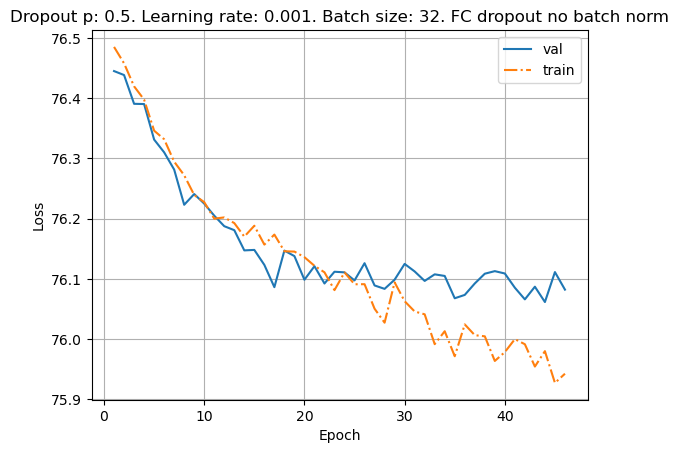   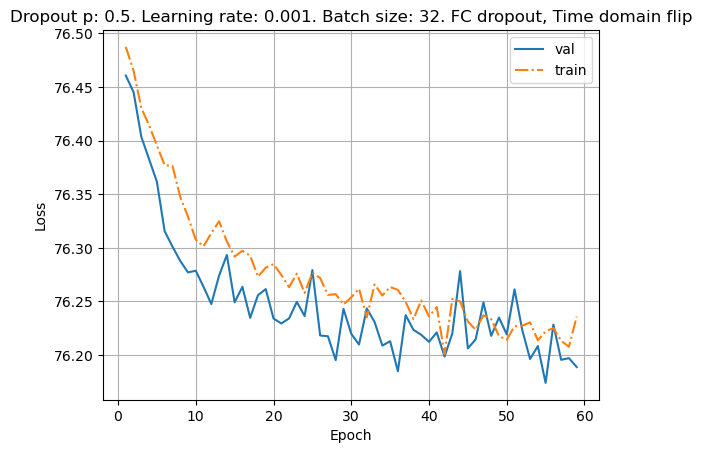   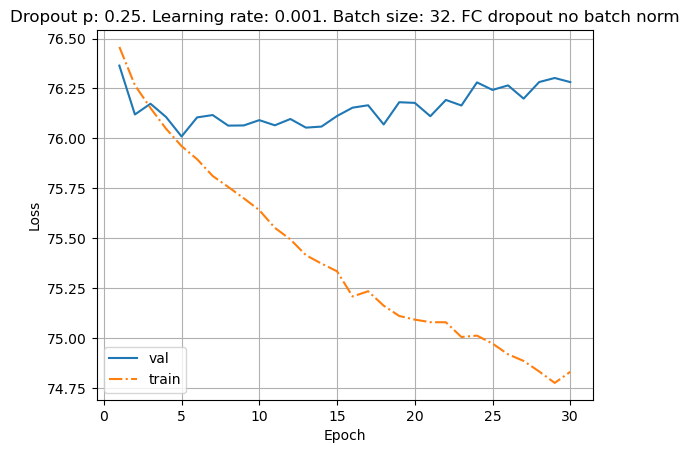 
  
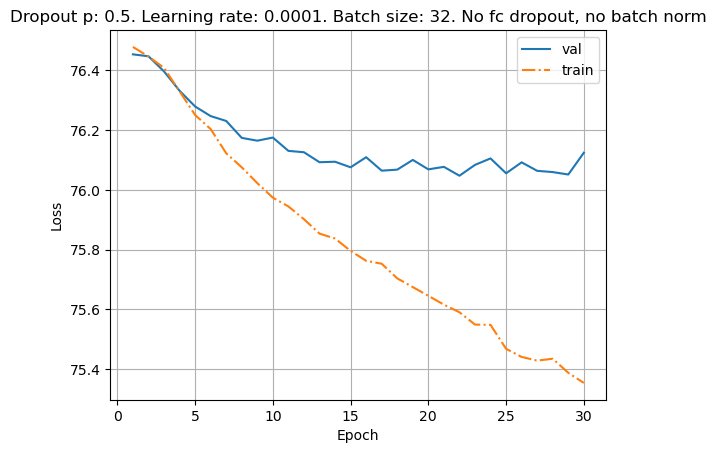  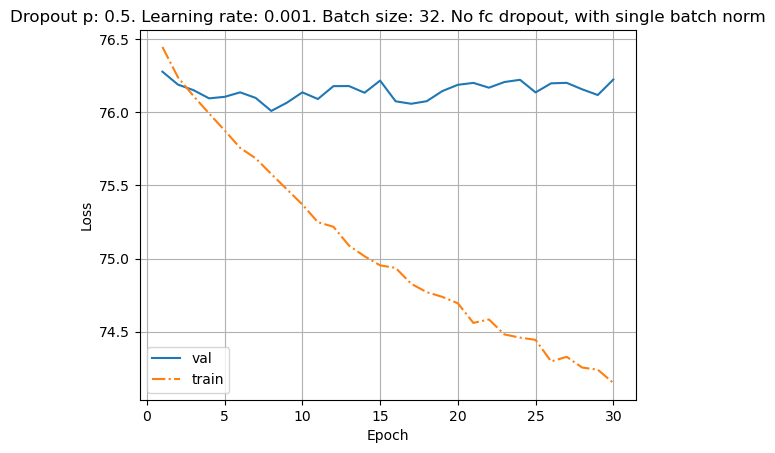    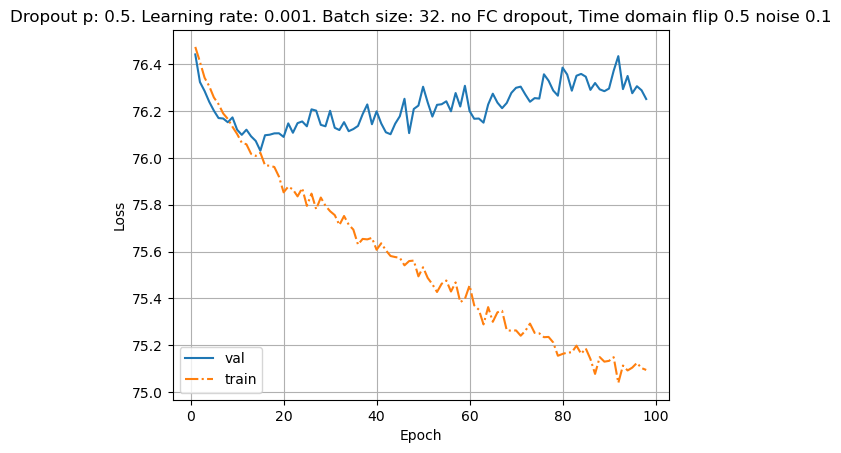  
![image.png] (attachment:image-9.png)
 
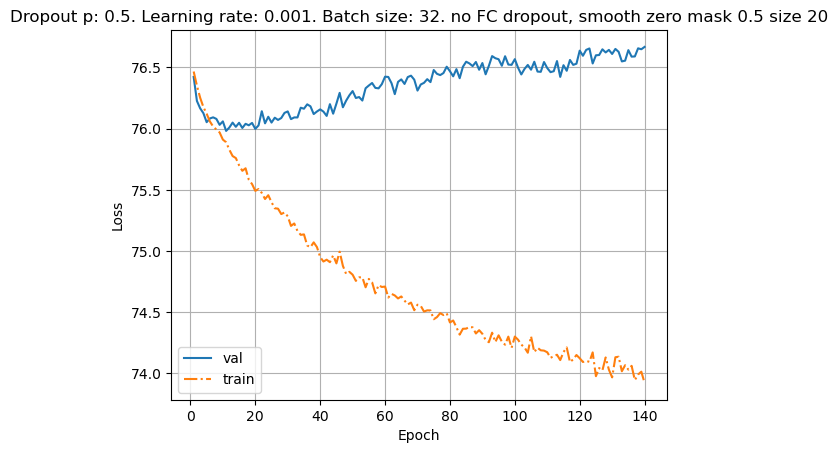     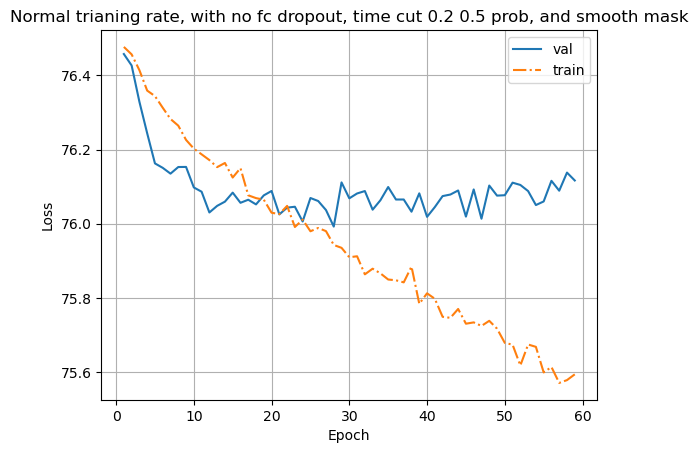

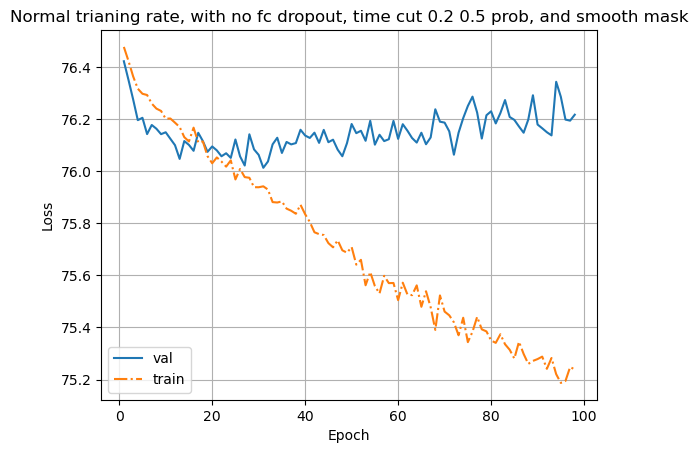   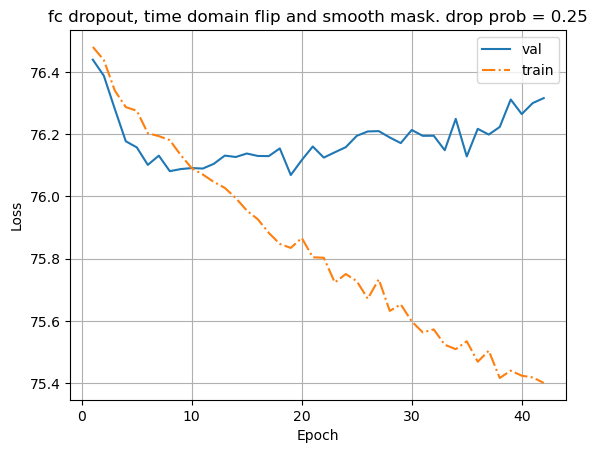